In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
#import is3_broker_rl
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#DATA_DIR = Path(is3_broker_rl.__file__).parent.parent / "data"

In [3]:
# Papermill parameter cell
# Name of the directory to analyse. Should contain consumption_action.csv and consumption_reward.csv.
ANALYSIS_DIR_NAME = "../data"#"/data/active/powertac/es22/is3-data"
COMMENTS = ""


In [4]:
print(COMMENTS)

In [5]:
#path = "../data/"
reward_prefix = "wholesale_reward.csv"

In [6]:
ANALYSIS_DIR = ANALYSIS_DIR_NAME

In [9]:
#path = "../data/"
reward_prefix = "SAC_1409_actionhist_bigger.csv"
#reward_prefix1 = "SAC_1009_trial4.csv"
reward_prefix2 = "wholesale_reward.csv"
reward_prefix3 = "wholesale_reward_SAC_new_reward_callbacks.csv"

In [10]:
# Papermill parameter cell
# Name of the directory to analyse. Should contain consumption_action.csv and consumption_reward.csv.
ANALYSIS_DIR_NAME = "../data"#"/data/active/powertac/es22/is3-data"
COMMENTS = ""
ANALYSIS_DIR = ANALYSIS_DIR_NAME
#df_reward = pd.read_csv(os.path.join(ANALYSIS_DIR,reward_prefix))
#df_reward1 = pd.read_csv(os.path.join(ANALYSIS_DIR,reward_prefix1))
df_reward2 = pd.read_csv(os.path.join(ANALYSIS_DIR,reward_prefix2))
df_reward3 = pd.read_csv(os.path.join(ANALYSIS_DIR,reward_prefix3))

### Reward analysis

<AxesSubplot:ylabel='reward'>

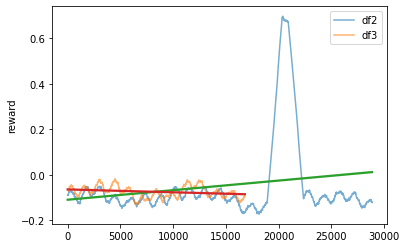

In [12]:
rolling = 2000
alpha= 0.7
#sns.lineplot(y=df_reward["reward"].rolling(rolling).mean().dropna(), x=np.arange(len(df_reward["reward"].rolling(rolling).mean().dropna())), label="df", alpha=alpha+0.2)
#sns.lineplot(y=df_reward1["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward1["reward"].rolling(rolling).mean().dropna())), label="df1", alpha=alpha)
sns.lineplot(y=df_reward2["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward2["reward"].rolling(rolling).mean().dropna())), label="df2", alpha=alpha-0.1)
sns.lineplot(y=df_reward3["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward3["reward"].rolling(rolling).mean().dropna())), label="df3", alpha=alpha-0.1)

#sns.regplot(y=df_reward["reward"].rolling(rolling).mean().dropna(), x=np.arange(len(df_reward["reward"].rolling(rolling).mean().dropna())), marker="")
#sns.regplot(y=df_reward1["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward1["reward"].rolling(rolling).mean().dropna())), marker="")
sns.regplot(y=df_reward2["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward2["reward"].rolling(rolling).mean().dropna())), marker="")
sns.regplot(y=df_reward3["reward"].rolling(rolling).mean().dropna(), x= np.arange(len(df_reward3["reward"].rolling(rolling).mean().dropna())), marker="")




In [ ]:
df_reward = pd.read_csv(os.path.join(ANALYSIS_DIR,reward_prefix))


In [16]:
# Fixes the issue that the experiment scheduler always assigns the same gameId
def write_unique_game_id(df):
    new_game_start_indices = df[df["timeslot"] < df["timeslot"].shift()].index
    if len(new_game_start_indices) > 0:
        df.loc[: new_game_start_indices[0], "gameId"] = f"game0"
        for i in range(len(new_game_start_indices) - 1):
            df.loc[new_game_start_indices[i] : new_game_start_indices[i + 1], "gameId"] = f"game{i + 1}"
        df.loc[new_game_start_indices[-1] :, "gameId"] = f"game{len(new_game_start_indices)}"

In [17]:
def min_max_scaler(series):
    return (series - series.min()) / (series.max() - series.min())

In [18]:
def calculate_customer_change(df):
    values = ((df["customer_count"] - df["customer_count"].shift(24)).fillna(0)).values
    df.loc[df.index, "customer_change"] = values
    return df

In [19]:
def convert_reward_csv_to_df(df_reward):
    df_reward.dropna(inplace=True) # Drop first few timesteps that have no action. 
    df_reward2 = df_reward["observation"].apply(json.loads)
    col_names = list(df_reward2.iloc[0].keys())
    df_reward2 = df_reward2.apply(lambda x: list(x.values()))
    temp_list = []
    for row in df_reward2:

        temp_list.append(row)

    temp_df = pd.DataFrame(temp_list, columns=col_names)

    temp_merge_df = pd.DataFrame()
    temp_name = []
    for column in temp_df.columns:
        if column != "action_hist":
            if type(temp_df[column].iloc[0]) == list:
                temp_df2 = temp_df[column].apply(pd.Series)
                i=0
                for column2 in temp_df2:
                    temp_merge_df[f"{column}_{i}"] = temp_df2[column2]
                    i+=1


            else:
                temp_merge_df[column] = temp_df[column]
        
    col_names = []
    price = []
    energy = []
    for i in range(24):
        col_names.append(f"energy_{i+1}")
        col_names.append(f"price_{i+1}")
        price.append(f"price_{i+1}")
        energy.append(f"energy_{i+1}")


    df_action = df_reward.apply(lambda x: x["last_action"].split(";"), result_type="expand", axis=1).drop(0, axis=1)
    df_action = df_action.astype(float)
    df_action.columns = col_names

    col_names = []
    price = []
    energy = []
    for i in range(24):
        col_names.append(f"raw_energy_{i+1}")
        col_names.append(f"raw_price_{i+1}")
        price.append(f"raw_price_{i+1}")
        energy.append(f"raw_energy_{i+1}")

    df_action2 = df_reward.apply(lambda x: x["raw_action"].split(";"), result_type="expand", axis=1).drop(0, axis=1)
    df_action2 = df_action2.astype(float)
    df_action2.columns = col_names

    action_observation_reward_df = pd.concat([df_action,temp_merge_df, df_reward[["reward", 
            "balancing_reward", "wholesale_reward","shaped_return","sum_mWh", "tariff_reward"]], df_action2],axis=1)
    write_unique_game_id(action_observation_reward_df)
    df = action_observation_reward_df
    #df = df[abs(df["sum_mWh"]) < 100] 
    
    return df

In [20]:
def analyze_action_for_timeslot(df, timeslot):
    # Or just use shift?
    index_slot = timeslot
    col_names_temp = ["reward", "customer_count"]
    templist = []
    for i in range(24):
        # -2 because bidding timeslots are closed 2 timeslots before. So the last bidding timeslot is handled 2 timeslots later.
        energy_price_bid = df.iloc[(index_slot - i-2)][[f"energy_{i+1}",f"price_{i+1}"]].values
        trade_result = df.iloc[index_slot - i][[f"cleared_orders_energy_{i}", f"cleared_orders_price_{i}"]].values
        market_position = df.iloc[index_slot -i ][f"market_position_{i}"]
        sum_mwh = df.iloc[index_slot ]["sum_mWh"]
        index_slot_list = df.iloc[index_slot-i].name
        predicted_prosumption=df.iloc[index_slot-i-2][f"p_customer_prosumption_{i}"]
        needed_mWh = df.iloc[index_slot-i-2][f"needed_mWh_{i}"]
        final_market_position = df.iloc[index_slot][f"shaped_return"]
        reward = df.iloc[index_slot][f"reward"]
        raw_action = df.iloc[(index_slot - i-2)][[f"raw_energy_{i+1}",f"raw_price_{i+1}"]].values
        overall_trade = df.iloc[index_slot - i][[f"cleared_trade_energy_{i}", f"cleared_trade_price_{i}"]].values

        #if i = 0:
        #    trade_result[0] = df.iloc[timeslot]["final"]
        templist.append([*energy_price_bid, *trade_result, market_position, index_slot_list, predicted_prosumption,  sum_mwh, 
            needed_mWh, final_market_position, reward, *raw_action, *overall_trade])

    df_action_analysis = pd.DataFrame(templist, columns=["energy_action", "price_action", "energy_orders", "price_orders",
        "market_position", "index_slot", "p_prosumption","sum_mWh",  "needed_mWh", 
        "final_market_pos", "reward", "raw_energy", "raw_price", "traded_energy", "traded_price"])
    return df_action_analysis
    #df_action_analysis

In [21]:
def style_df(df):
    return df.style.background_gradient(cmap="bwr", vmin=-15, vmax=15, axis =0)

In [22]:
df = convert_reward_csv_to_df(df_reward)
if "customer_change" not in df.columns:
    df = calculate_customer_change(df)
col_names = []
price = []
energy = []
for i in range(24):
    col_names.append(f"energy_{i+1}")
    col_names.append(f"price_{i+1}")
    price.append(f"price_{i+1}")
    energy.append(f"energy_{i+1}")


/tmp/ipykernel_21727/254991163.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp_merge_df[f"{column}_{i}"] = temp_df2[column2]
/tmp/ipykernel_21727/254991163.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp_merge_df[f"{column}_{i}"] = temp_df2[column2]
/tmp/ipykernel_21727/254991163.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

### Add customer_change

In [23]:
df_reward_rolling = df["reward"].rolling(20).mean().dropna()
df_balancing_reward = df["balancing_reward"].rolling(1).mean().dropna()
df_wholesale_reward = df["wholesale_reward"].rolling(1).mean().dropna()
df_tariff_reward = df["tariff_reward"].rolling(1).mean().dropna()
#df_shaped = df_reward["shaped_return"].rolling(20).mean().dropna()

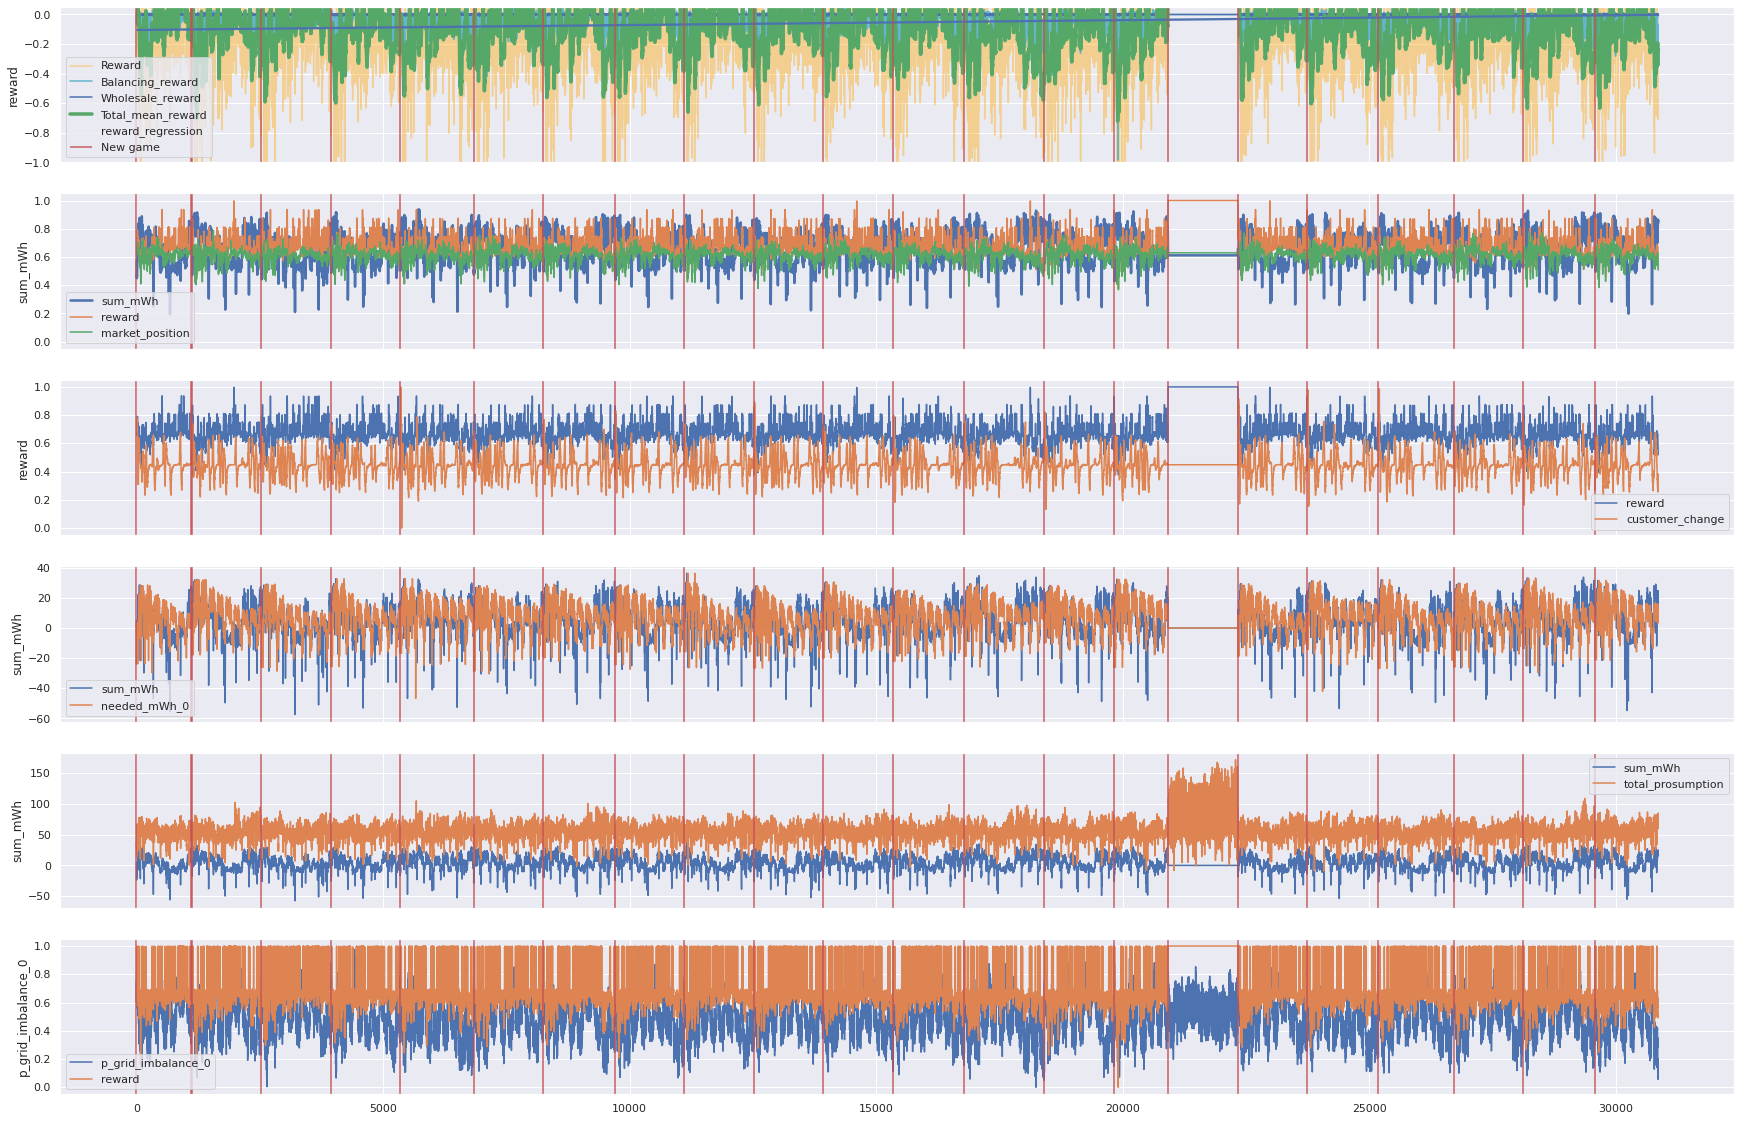

In [24]:

sns.set_theme()
sns.axes_style("darkgrid")
f, axs = plt.subplots(6, 1, sharex=True)



#graph5 = sns.lineplot(x=df_tariff_reward.index, y=df_tariff_reward, ax=axs, label="Tariff_reward")
#graph6 = sns.lineplot(x=df_shaped.index, y=df_shaped, ax=axs, label="Shaped_reward", color="green")

# plot 1: reward over time
graph7 = sns.lineplot(x=df.index, y=df["reward"], color="orange", ax=axs[0], alpha=0.4, label="Reward")

graph3 = sns.lineplot(x=df_balancing_reward.index, y=df_balancing_reward, ax=axs[0], label="Balancing_reward", color="c")
graph4 = sns.lineplot(x=df_wholesale_reward.index, y=df_wholesale_reward, ax=axs[0],label="Wholesale_reward", color="b")
graph2 = sns.lineplot(x=df_reward_rolling.index, y=df_reward_rolling, ax=axs[0], label="Total_mean_reward", linewidth= 3.5, color="g")
graph8 = sns.regplot(x=df_reward_rolling.index, y=df_reward_rolling, marker="", label="reward_regression", ax=axs[0])
# plot 2: reward over time with prosumption
graph9 = sns.lineplot(x=df.index, y=min_max_scaler(df["sum_mWh"]).rolling(5).mean(), data=df, ax=axs[1], label="sum_mWh", linewidth= 2.5)
graph9 = sns.lineplot(x=df.index, y=min_max_scaler(df["reward"]).rolling(5).mean(), data=df, ax=axs[1], label="reward")
sns.lineplot(x=df.index, y=min_max_scaler(df["market_position_0"]).rolling(5).mean(), data=df, ax=axs[1], label="market_position")
# plot 3: balancing reward with customer.
sns.lineplot(x=df.index, y=min_max_scaler(df["reward"]).rolling(5).mean(), data=df, ax=axs[2], label="reward")
sns.lineplot(x=df.index, y=min_max_scaler(df["customer_change"]), data=df, ax=axs[2], label="customer_change")
# plot 4: Customer_prosumption:
sns.lineplot(x=df.index, y=(df["sum_mWh"]).rolling(1).mean(), data=df, ax=axs[3], label="sum_mWh")
sns.lineplot(x=df.index, y=(df["needed_mWh_0"]).rolling(1).mean(), data=df, ax=axs[3], label="needed_mWh_0")    


# plot 5: Our prosumption vs total prosumption:
sns.lineplot(x=df.index, y=(df["sum_mWh"]).rolling(1).mean(), data=df, ax=axs[4], label="sum_mWh")
sns.lineplot(x=df.index, y=(df["total_prosumption"]).rolling(1).mean()/-1000, data=df, ax=axs[4], label="total_prosumption")    

# plot 6: Our prosumption vs total prosumption:
sns.lineplot(x=df.index, y=min_max_scaler(df["p_grid_imbalance_0"]).rolling(1).mean(), data=df, ax=axs[5], label="p_grid_imbalance_0")
sns.lineplot(x=df.index, y=min_max_scaler((df["reward"]).rolling(1).mean()), data=df, ax=axs[5], label="reward")    




for ax in axs:
    ax.vlines(
            df[df["gameId"].shift() != df["gameId"]].index,
            0,
            1,
            transform=ax.get_xaxis_transform(),
            colors="r",
            alpha=0.9,
            label="New game",
        )
axs[0].legend()
axs[1].set_ylabel("sum_mWh")
axs[0].set_ybound(-1,0.05)
f.set_figwidth(30)
f.set_figheight(20)


In [25]:
df["p_grid_imbalance_0"].quantile([0.25,0.5,0.75])

0.25   -27776.256836
0.50   -17398.267578
0.75    -5421.645752
Name: p_grid_imbalance_0, dtype: float64

In [26]:
dfgame = df[(df["gameId"] == "game9")] #& (df["reward"] < -1)]

<AxesSubplot:ylabel='needed_mWh_0'>

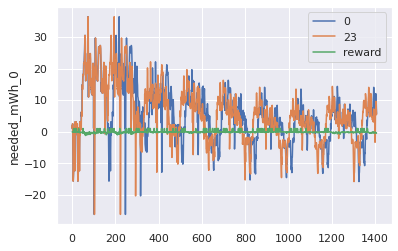

In [27]:
sns.lineplot(y=dfgame["needed_mWh_0"], x= range(len(dfgame)), label="0")
sns.lineplot(y=dfgame["needed_mWh_23"], x= range(len(dfgame)), label="23")
sns.lineplot(y=dfgame["reward"], x= range(len(dfgame)), label="reward")


<AxesSubplot:xlabel='needed_mWh_0', ylabel='reward'>

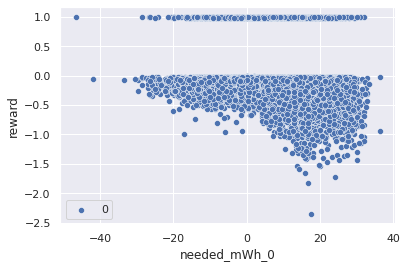

In [28]:
sns.scatterplot(x=df["needed_mWh_0"], y= df["reward"], label="0")
#sns.scatterplot(x=dfgame["needed_mWh_23"].shift(23),y= dfgame["reward"], label="23", alpha=0.3)
#sns.lineplot(y=dfgame["reward"], x= range(len(dfgame)), label="reward")

<AxesSubplot:xlabel='sum_mWh', ylabel='reward'>

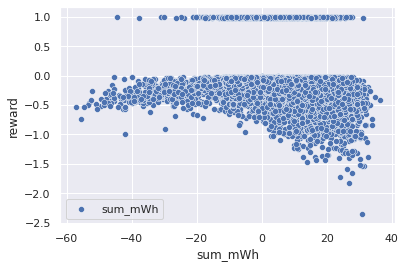

In [29]:
sns.scatterplot(x=df["sum_mWh"], y= df["reward"], label="sum_mWh")

/home/lorenz/is3-broker-rl/venv/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


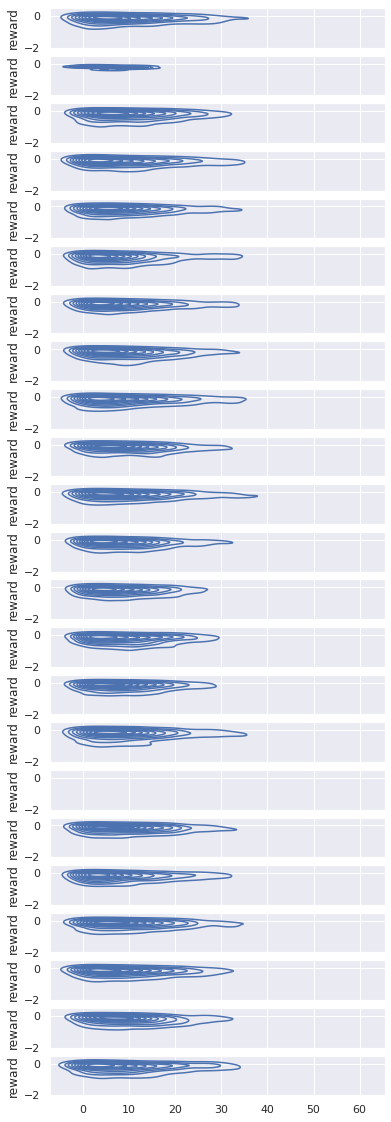

In [30]:
fig, axs = plt.subplots(len(list(df["gameId"].unique())),1, sharex=True, sharey=True)
fig.set_figheight(20)
i=0
for game in list(df["gameId"].unique()):
    dftemp = df[df["gameId"] == game]
    temp= abs(dftemp["sum_mWh"] - dftemp["needed_mWh_0"])
    sns.kdeplot(x=temp, y= dftemp["reward"], label=game, alpha=1, ax=axs[i])
    axs[i].set_ybound(0.5,-2)
    i+=1



<AxesSubplot:ylabel='reward'>

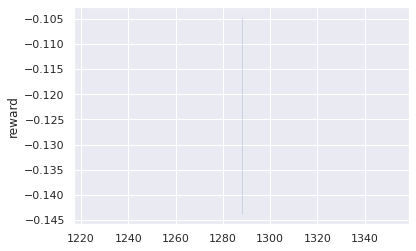

In [31]:
#for game in list(df["gameId"].unique()):
game="game22"
sns.lineplot(y=df[df["gameId"] == game]["reward"],x=len(df[df["gameId"] == game]))

In [32]:
sns.lineplot(x=df["sum_mWh"].index ,y=((df["sum_mWh"]).rolling(1).mean()), data=df["sum_mWh"] , ax=ax, label="sum_mWh", alpha=0.5)
sns.lineplot(x=df["reward"].index ,y=((df["reward"]).rolling(1).mean()), data=df["reward"] , ax=ax, label="reward", alpha=1)

<AxesSubplot:ylabel='p_grid_imbalance_0'>

<AxesSubplot:ylabel='market_position_0'>

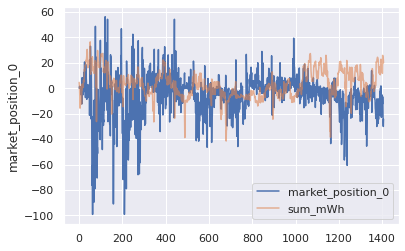

In [33]:
sns.lineplot(y=dfgame["market_position_0"], x= range(len(dfgame)), label="market_position_0")
sns.lineplot(y=dfgame["sum_mWh"], x= range(len(dfgame)), label="sum_mWh" ,alpha=0.6)
#sns.lineplot(y=dfgame["reward"], x= range(len(dfgame)), label="reward")

In [34]:
(abs(df["needed_mWh_23"] - df["sum_mWh"].shift(-22))).mean()

8.816550969412214

<AxesSubplot:ylabel='reward'>

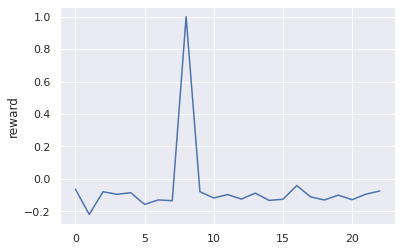

In [35]:
# mean reward per game:
df_game = df.groupby("gameId").mean()

sns.lineplot(x=range(len(df_game)), y= df_game["reward"])

### Performance Analysis

In [28]:
# Look at information provided 
temp_mean = []
temp_std = []
temp_name = []
print("{")
for column in df.columns:
    if column!="gameId":
        print(f"\'{column}\': {df[column].std()},")#, {df[column].std()},")
        temp_name.append(column)
        temp_mean.append(df[column].mean())
        temp_std.append(df[column].std())
        
print("}")

df_stats = pd.DataFrame(np.array([temp_name,temp_mean,temp_std]).ravel().reshape((3,-1))).T.set_index(0)
df_stats = df_stats.rename({1: "mean", 2 : "std"}, axis=1)
#df_stats

{
'energy_1': 4.69611667004982,
'price_1': 33.47347189226797,
'energy_2': 4.7435883714870775,
'price_2': 19.629975821405445,
'energy_3': 4.844445658301833,
'price_3': 21.39960702781274,
'energy_4': 4.814484472002863,
'price_4': 20.94649287463517,
'energy_5': 4.881053617432295,
'price_5': 22.59082876665822,
'energy_6': 4.804469371050254,
'price_6': 21.6067463816991,
'energy_7': 4.8543040310394865,
'price_7': 22.541803647421343,
'energy_8': 4.787032890215659,
'price_8': 24.18458840968842,
'energy_9': 4.726486537950636,
'price_9': 25.33515193855204,
'energy_10': 4.787164025882194,
'price_10': 25.148741424893625,
'energy_11': 4.804826707591641,
'price_11': 24.793884873381447,
'energy_12': 4.7420407035388425,
'price_12': 24.162629384222903,
'energy_13': 4.777959360824685,
'price_13': 26.09815779973974,
'energy_14': 4.838732468394804,
'price_14': 26.25637545421496,
'energy_15': 4.818735702195903,
'price_15': 25.28257852382927,
'energy_16': 4.770816176493258,
'price_16': 27.3289209848285,
'en

### Better sum_mWh prediction

<AxesSubplot:>

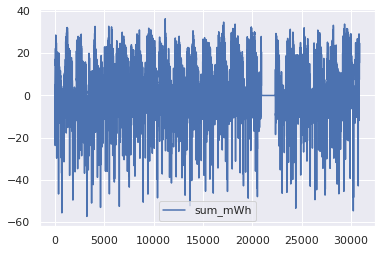

In [29]:
diff_i = 23
df_pred = ((df["sum_mWh"]) - ((df[f"p_customer_prosumption_{diff_i}"])/-1000))
sns.lineplot(x=range(len(df_pred)), y=df_pred, label="sum_mWh")
#sns.lineplot(x=df.index, y=, data=df, ax=axs[4], label="p_customer_prosumption_0") 

In [30]:
df_pred = df_pred.shift(-diff_i).dropna()


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = df[df.columns.difference(["gameId", "sum_mWh"])]
X = X[:len(X)-diff_i]
#y = df["sum_mWh"].shift(-diff_i).dropna()
y = df_pred

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, shuffle=False)

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor



rf = RandomForestRegressor(warm_start=True, n_estimators=20, max_features="sqrt")
rf.fit(X_train, y_train)
#sarimax.

CPU times: user 4.24 s, sys: 49.7 ms, total: 4.29 s
Wall time: 4.28 s


RandomForestRegressor(max_features='sqrt', n_estimators=20, warm_start=True)

In [35]:
%%time
rf.fit(X_val, y_val)

CPU times: user 0 ns, sys: 16.1 ms, total: 16.1 ms
Wall time: 13.6 ms


/home/lorenz/is3-broker-rl/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


RandomForestRegressor(max_features='sqrt', n_estimators=20, warm_start=True)

In [36]:
rf.score(X_test, y_test)

0.8105353494982621

In [37]:
pred = rf.predict(df[df.columns.difference(["gameId", "sum_mWh"])])

<AxesSubplot:ylabel='sum_mWh'>

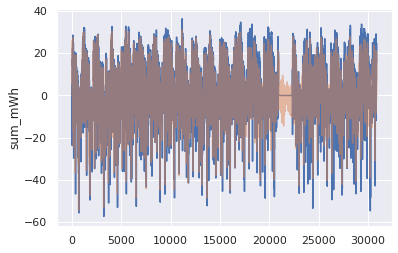

In [38]:
sns.lineplot(y=df[df.columns.difference(["gameId"])]["sum_mWh"], x=range(len(df[df.columns.difference(["gameId"])])))
sns.lineplot(y=pd.Series(pred).rolling(1).mean(), x=range(len(pred)), alpha=0.5)

In [39]:
from sklearn.neighbors import KNeighborsRegressor

In [40]:
%%time
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

CPU times: user 15.7 ms, sys: 19.9 ms, total: 35.6 ms
Wall time: 32.4 ms


KNeighborsRegressor()

In [41]:
%%time
rf.fit(X_val, y_val)

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 9.99 ms


/home/lorenz/is3-broker-rl/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


RandomForestRegressor(max_features='sqrt', n_estimators=20, warm_start=True)

In [42]:
knn.score(X_test, y_test)

0.671396158606255

### Production prediction:
SolarLeasing = 5
SunnyhillSolar = 13
WindmillCoOp = 17
Battery = 10


<AxesSubplot:>

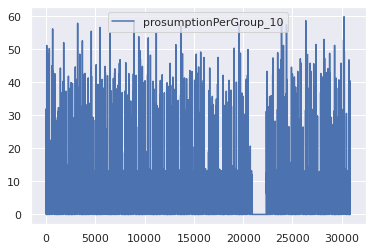

In [43]:
diff_i = 5
group = 10
#df_pred = ((df[f"prosumptionPerGroup_{group}"]))
df_pred = (df[f"prosumptionPerGroup_5"] + df[f"prosumptionPerGroup_13"] + df[f"prosumptionPerGroup_17"]) /1000
sns.lineplot(x=range(len(df_pred)), y=df_pred, label=f"prosumptionPerGroup_{group}")
#sns.lineplot(x=df.index, y=, data=df, ax=axs[4], label="p_customer_prosumption_0") 

In [44]:
X = df[df.columns.difference(["gameId", "prosumptionPerGroup_{group}"])]
X = X[:len(X)-diff_i +2]
#y = df[f"prosumptionPerGroup_{group}"].shift(-diff_i +2).dropna() /1000
y = (df[f"prosumptionPerGroup_5"] + df[f"prosumptionPerGroup_13"] + df[f"prosumptionPerGroup_17"]).shift(-diff_i +2).dropna() /1000


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, shuffle=False)

In [46]:
rf_prod = RandomForestRegressor(warm_start=True, n_estimators=5, max_features="sqrt")
rf_prod.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=5, warm_start=True)

In [47]:
%%time
rf_prod.fit(X_val, y_val)

CPU times: user 4.07 ms, sys: 10.2 ms, total: 14.2 ms
Wall time: 12.7 ms


/home/lorenz/is3-broker-rl/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


RandomForestRegressor(max_features='sqrt', n_estimators=5, warm_start=True)

In [48]:
rf_prod.score(X_test, y_test)

0.8852967406690223

In [49]:
pred = rf_prod.predict(df[df.columns.difference(["gameId"])])

<AxesSubplot:>

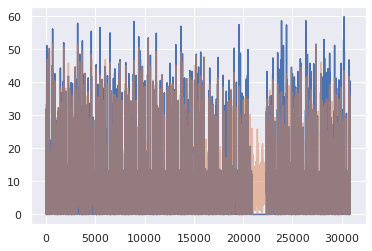

In [50]:
plot_y =((df[f"prosumptionPerGroup_5"] + df[f"prosumptionPerGroup_13"])+ df[f"prosumptionPerGroup_17"] ).shift(0).dropna() /1000
sns.lineplot(y=plot_y, x=range(len(plot_y)))
sns.lineplot(y=pd.Series(pred).rolling(1).mean(), x=range(len(pred)), alpha=0.5)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_test = rf_prod.predict(X_test)
mae = mean_absolute_error(y_test, pred_test)
prosumption = y_test.mean()
print(f"Avg prosumption test set: {prosumption}, MEA: {mae}")

Avg prosumption test set: 8.639652181464678, MEA: 0.9055091411535968


### Rest Prediction:


In [52]:
df["needed_mWh_0"]

0         1.945176
1         2.009759
2         2.235141
3         2.094355
4        -4.331953
           ...    
30857    15.762855
30858    14.580762
30859    10.924102
30860     7.691574
30861     7.021717
Name: needed_mWh_0, Length: 30862, dtype: float64

### Customer and Market analysis:

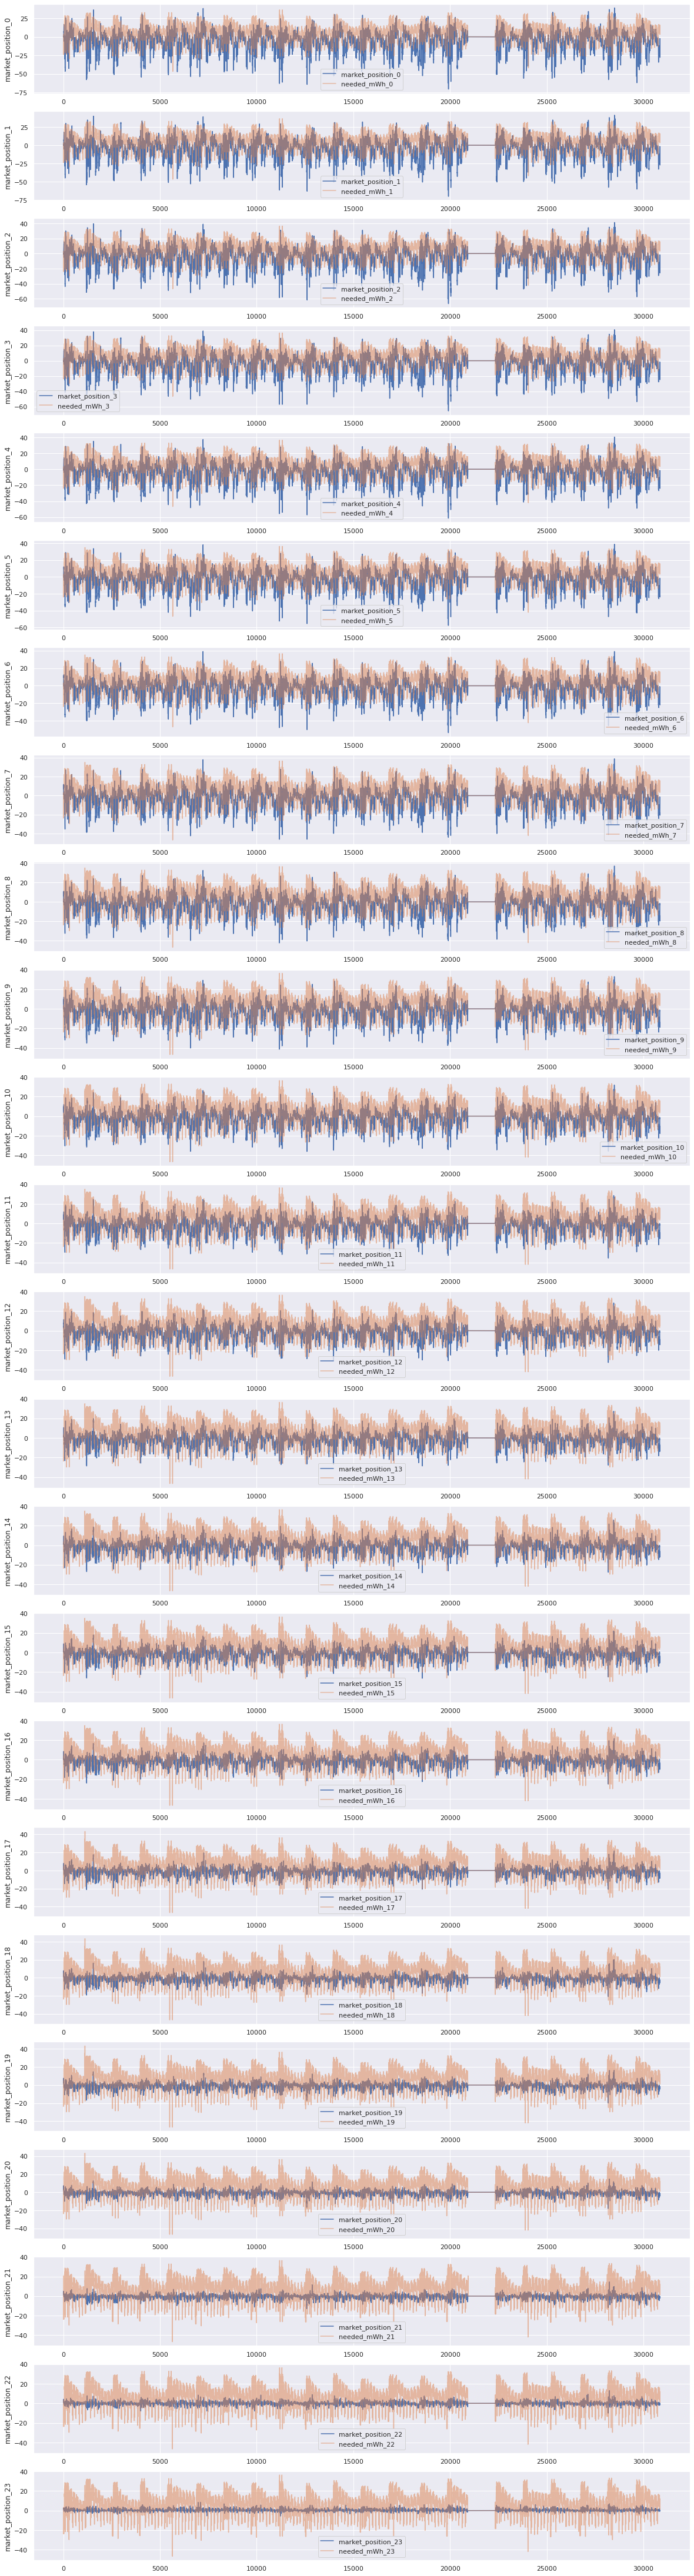

In [53]:
fig, axs = plt.subplots(24,1, sharey=False)
i=0
j=0
for col in df.columns:
    if "market" in col:
        sns.lineplot(x=df[col].index ,y=(df[col].rolling(10).mean()), data=df[col] , ax=axs[i], label=col)
        #sns.lineplot(x=df.index, y=min_max_scaler(df["reward"]).rolling(5).mean(), data=df, ax=axs[i], label="reward")
        i+=1
        
       
        #axs[i].legend()
    if "needed" in col:
        sns.lineplot(x=df[col].index ,y=(df[col].rolling(1).mean()), data=df[col] , ax=axs[j], label=col, alpha=0.5)
        j+=1
        
#for ax in axs:
#    sns.lineplot(x=df["sum_mWh"].index ,y=(df["sum_mWh"]).rolling(1).mean(), data=df["sum_mWh"] , ax=ax, label="sum_mWh", alpha=0.5)
    #sns.lineplot(x=df["reward"].index ,y=((df["reward"]).rolling(1).mean()), data=df["reward"] , ax=ax, label="reward", alpha=1)

fig.set_figwidth(20)
fig.set_figheight(80)



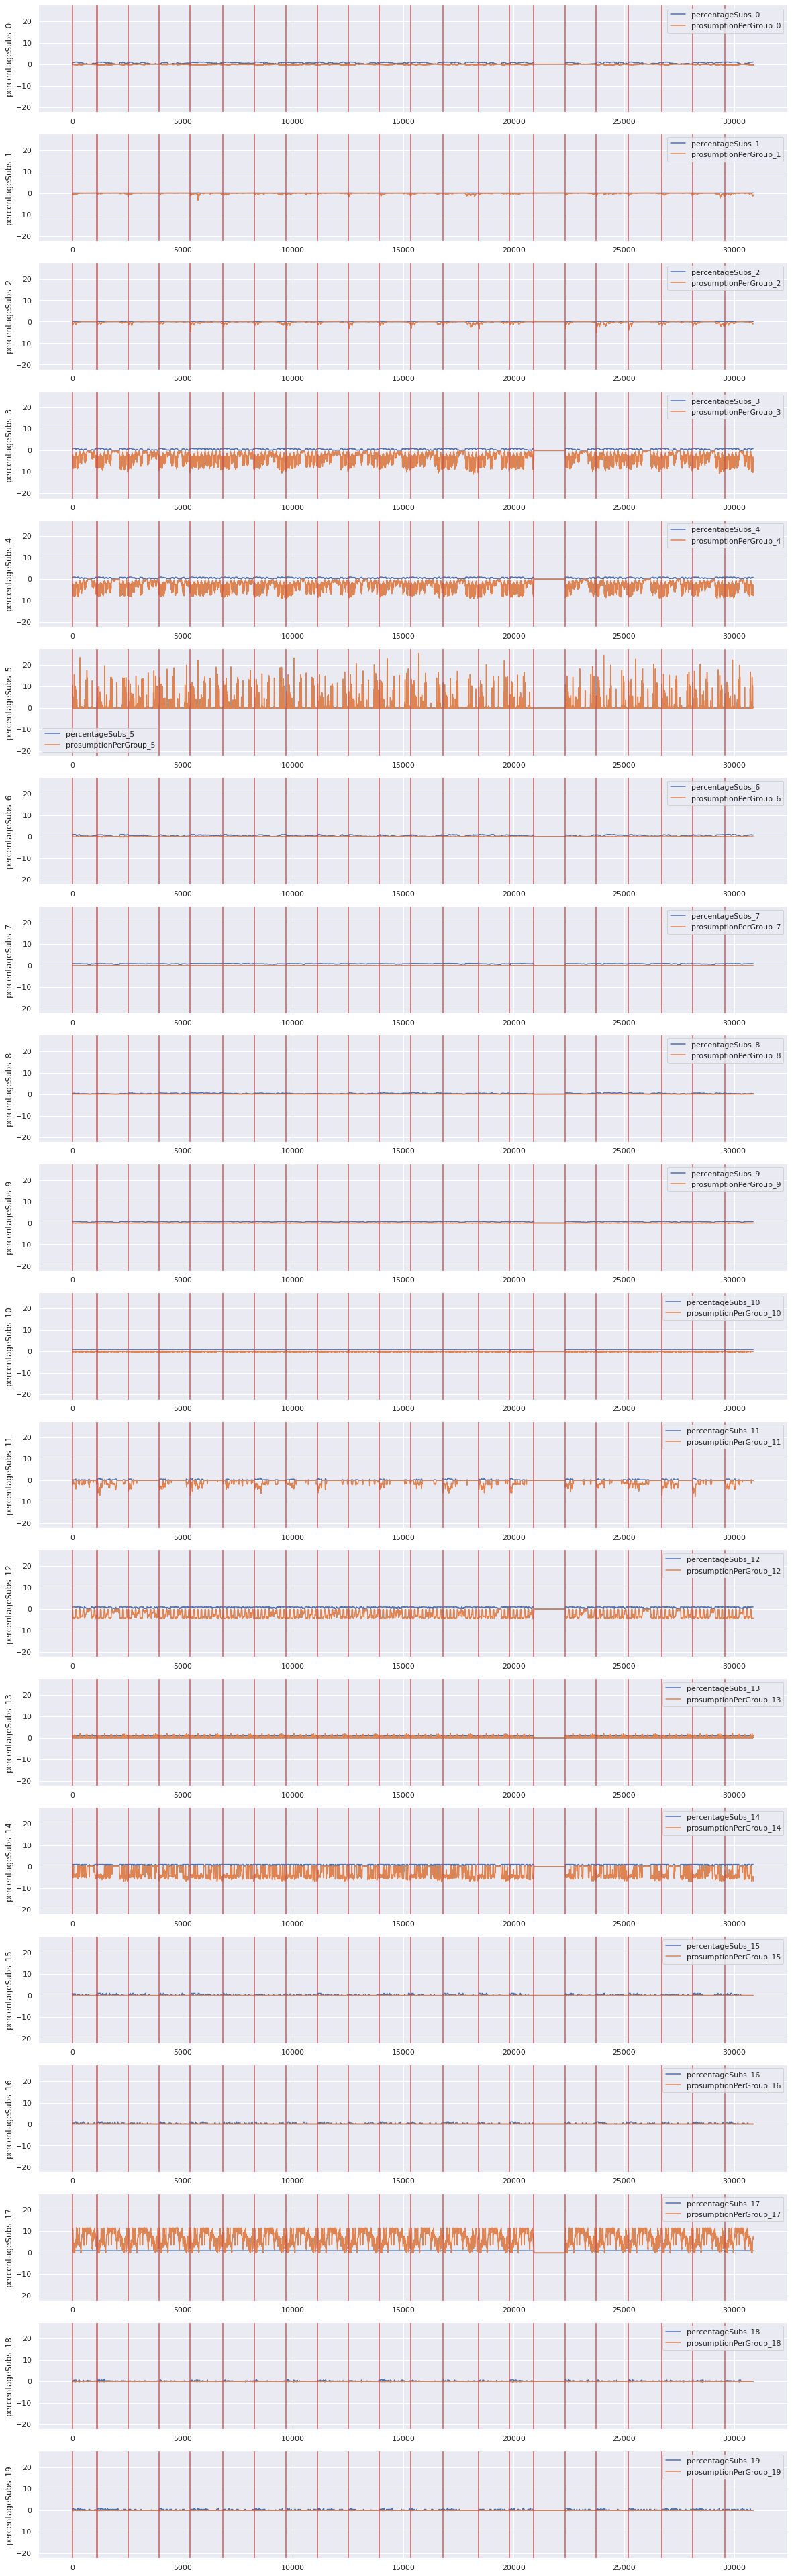

In [54]:
fig, axs = plt.subplots(20,1, sharey=True)
i=0
j=0
for col in df.columns:
    if "percentageSubs" in col:
        sns.lineplot(x=df[col].index ,y=(df[col].rolling(10).mean()), data=df[col] , ax=axs[i], label=col)
        #sns.lineplot(x=df.index, y=min_max_scaler(df["reward"]).rolling(5).mean(), data=df, ax=axs[i], label="reward")
        i+=1
        
       
        #axs[i].legend()
    if "prosumptionPerGroup" in col:
        sns.lineplot(x=df[col].index ,y=(df[col].rolling(10).mean()/1000), data=df[col] , ax=axs[j], label=col)
        j+=1
        
#axs[0].set_ybound(-30,5)
fig.set_figwidth(20)
fig.set_figheight(70)
for ax in axs:
    ax.vlines(
            df[df["gameId"].shift() != df["gameId"]].index,
            -20,5,
            transform=ax.get_xaxis_transform(),
            colors="r",
            alpha=0.9,
            label="New game",
        )

<AxesSubplot:ylabel='reward'>

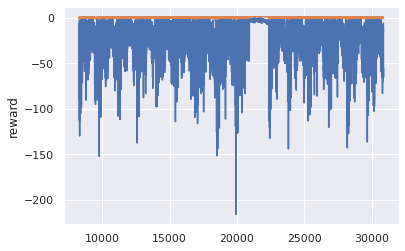

In [55]:
temp_df3 = abs(((abs(df["p_customer_prosumption_0"])) - df["market_position_0"])) * -1

temp_df3 =temp_df3.iloc[8300:]
sns.lineplot(x=temp_df3.index, y=temp_df3)
sns.lineplot(x=temp_df3.index, y= df["reward"].iloc[8300:])

In [56]:
for index, name in df[df["reward"] < 0.1].corr()["reward"].sort_values().iteritems():
    print(f"{index}, {name}")

tariff_reward, -0.40050644452776685
sum_mWh, -0.36699173569940635
percentageSubs_4, -0.3563876661929631
percentageSubs_3, -0.3518901002230648
needed_mWh_0, -0.33924269784078237
needed_mWh_1, -0.3092260795886249
needed_mWh_11, -0.29211362242584055
needed_mWh_10, -0.28728959035050744
needed_mWh_22, -0.2872178601429371
needed_mWh_2, -0.2841908474169143
needed_mWh_12, -0.28138424918839383
needed_mWh_21, -0.27685759838464996
needed_mWh_4, -0.27187274632773667
needed_mWh_9, -0.27152910859574675
needed_mWh_3, -0.270274489677213
needed_mWh_8, -0.26767878567357756
needed_mWh_23, -0.26567635429580033
needed_mWh_13, -0.26535027650287435
needed_mWh_5, -0.26510166440910243
needed_mWh_7, -0.2620397661323855
percentageSubs_9, -0.25821744949333164
needed_mWh_6, -0.25818419344548377
percentageSubs_14, -0.2564459344919723
needed_mWh_14, -0.2487193738177288
needed_mWh_20, -0.2461495710397023
customer_count, -0.24223831765410284
percentageSubs_6, -0.24132469989818822
needed_mWh_15, -0.2376146012935019
per

In [57]:
temp_df = df[df["reward"] < -1]

In [58]:
temp_df.tail(50)

energy_1    price_1   energy_2    price_2   energy_3    price_3  \
14004   0.000000  -0.000000   1.994726  -1.418339   4.811241  -1.952103   
15433 -18.836682   8.163897   0.000000  -0.000000   5.301166  -0.322257   
15435   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
16586   6.216789  -2.092339  -1.495620   1.189422   0.000000  -0.000000   
16875   0.000000  -0.000000 -10.701386   1.328978   0.000000  -0.000000   
16877   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
16878   0.000000  -0.000000  -6.773119   0.145719   0.000000  -0.000000   
16901   1.698209  -7.644206  -3.593036   2.918699  -3.546467  24.757991   
17071   6.952494 -17.471069   0.000000  -0.000000 -12.859049   0.381577   
17077  -8.486225   1.402198   0.000000  -0.000000  10.838763 -11.824682   
18486   0.000000  -0.000000 -22.421260   8.871158   0.000000  -0.000000   
18499  10.762243  -0.069147   0.000000  -0.000000   0.000000  -0.000000   
18570   0.005037  -2.091604   0.000000  -0.000000  14.181726  -0.625171   
18571  -5.854013   1.451080   1.339883  -1.617480   0.000000  -0.000000   
18692   0.000000  -0.000000   5.489937  -0.092921  13.718917  -0.208773   
19147   0.000000  -0.000000   0.000000  -0.000000   1.525353  -6.681639   
19886  19.149734 -23.566092  11.995987  -0.703782  -0.436715   0.107859   
19887  -1.442628   2.977101   0.000000  -0.000000  -9.047035   0.313759   
19894 -15.885766   1.355844  18.505396  -1.736900 -22.800018   1.177419   
19911   6.169941  -0.023265 -11.110991   1.035731   7.151952  -0.848748   
19912   4.465198  -1.736672  -1.516794   1.733101   0.000000  -0.000000   
19919   7.758096  -1.060604   0.000000  -0.000000   0.000000  -0.000000   
19934   0.000000  -0.000000   0.000000  -0.000000  10.520865  -4.273079   
19983   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
20029   0.000000  -0.000000  -7.118805   3.370052  10.917667  -3.674715   
20043  15.505718 -60.646840  -0.024499  10.744334   0.000000  -0.000000   
20053   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
22400   0.000000  -0.000000   8.829361  -1.848782   0.000000  -0.000000   
22411   0.000000  -0.000000  -8.284099  17.595135   0.000000  -0.000000   
22423  11.112365  -0.076029   0.000000  -0.000000   0.000000  -0.000000   
23810 -22.424458  43.197817 -16.577740  41.609302  -9.131625  51.863684   
23846   0.000000  -0.000000   9.370466  -0.061472   0.000000  -0.000000   
23847  10.591040  -2.331243   0.000000  -0.000000  11.732508 -14.749453   
25268   0.000000  -0.000000   0.000000  -0.000000 -10.125506   0.697581   
25269   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
25271   0.000000  -0.000000  -6.332153   1.987576   0.000000  -0.000000   
25396  11.257317 -10.493442 -17.724061   1.533627   0.000000  -0.000000   
26797   0.000000  -0.000000  -6.668716   1.015956   0.000000  -0.000000   
26819   0.000000  -0.000000 -13.240035   1.228594   0.000000  -0.000000   
26916   0.000000  -0.000000   0.136379  -4.790861   0.000000  -0.000000   
28175   0.000000  -0.000000   8.500225  -1.548225   0.000000  -0.000000   
28192  28.422037  -1.633892 -17.684902   1.748106   0.000000  -0.000000   
28193   0.000000  -0.000000   0.000000  -0.000000  -9.632576   1.946562   
28194   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
28195   0.000000  -0.000000   0.000000  -0.000000   2.132882  -1.734721   
28266   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
28267   0.000000  -0.000000   0.000000  -0.000000   5.966811  -1.217015   
29659   0.000000  -0.000000   0.000000  -0.000000   0.000000  -0.000000   
29660   0.000000  -0.000000   0.000000  -0.000000  -2.302070   1.452122   
29731   0.000000  -0.000000   0.000000  -0.000000  -2.490977   0.837866   

        energy_4    price_4   energy_5    price_5  ...  raw_energy_20  \
14004   0.000000  -0.000000   0.000000  -0.000000  ...       0.402332   
15433   0.000000  -0.000000   0.0000

In [59]:
try:
    style_df(analyze_action_for_timeslot(df, 5000))
except:
    print("Wrong timeslot set.")

In [60]:
abs(temp_df["needed_mWh_0"].shift(0) - temp_df["sum_mWh"]).mean()

8.767088838021646

In [61]:
# Problem: Low reward comes from selling energy to often.
df.loc[df["reward"] < -1]["shaped_return"].quantile([0.25,0.5,0.75,0.98,0.99, 0.999])


0.250   -106.389621
0.500    -94.562980
0.750    -82.953626
0.980    -74.319738
0.990    -73.677048
0.999    -73.510685
Name: shaped_return, dtype: float64

In [62]:
df[df["reward"]< -1][["cleared_trade_energy_0", "cleared_trade_energy_1", "cleared_trade_energy_2", 
"cleared_orders_energy_0", "cleared_orders_energy_1", "cleared_orders_energy_2"]].mean()

cleared_trade_energy_0     6.048410
cleared_trade_energy_1     4.084955
cleared_trade_energy_2     3.843991
cleared_orders_energy_0   -4.127172
cleared_orders_energy_1   -2.721111
cleared_orders_energy_2   -1.535121
dtype: float64

In [63]:
for index, value in df[df.columns.difference(pd.Index(["gameId"]))].corr()["reward"].sort_values().iteritems():
    
    print(index, value)

percentageSubs_10 -0.5473003420673264
percentageSubs_13 -0.5466285992752759
percentageSubs_7 -0.5032345173211309
percentageSubs_9 -0.48212376313717686
percentageSubs_17 -0.4516781725517544
percentageSubs_14 -0.43154778646797687
percentageSubs_3 -0.3954575114281491
percentageSubs_4 -0.3952457842501198
percentageSubs_12 -0.3870918923538952
tariff_reward -0.33045549028169313
percentageSubs_0 -0.31917068270695753
percentageSubs_6 -0.30707356923844203
percentageSubs_8 -0.29797380601402557
needed_mWh_0 -0.27623789247579755
needed_mWh_1 -0.26301063123730434
sum_mWh -0.2561075461867841
customer_count -0.25424554677512873
needed_mWh_2 -0.252106658320902
needed_mWh_4 -0.24180617881200467
needed_mWh_11 -0.241337218339568
needed_mWh_3 -0.2412737541997199
needed_mWh_10 -0.23896941954676262
needed_mWh_5 -0.23787226093198569
needed_mWh_12 -0.23737431737539133
needed_mWh_9 -0.2316954026998632
needed_mWh_8 -0.23103033915480495
needed_mWh_6 -0.23072795787917905
needed_mWh_13 -0.230059432936493
needed_mW

In [64]:
df2 = pd.DataFrame()
df2["predicted_consumption_mWh"] = df["p_customer_prosumption_0"] /-1000
df2["timeslot"] = df["timeslot"]
df2["market_position_0"] = df["market_position_0"]
df2["sum_mWh"] = df["sum_mWh"]
df2["error_prediction"] = abs(df2["sum_mWh"]) - df2["predicted_consumption_mWh"]
df2

predicted_consumption_mWh  timeslot  market_position_0    sum_mWh  \
0                       0.000512       363           0.000000   5.159000   
1                       0.002229       364           0.000000   2.235141   
2                       0.002554       365           0.000000   2.094355   
3                       0.002481       366           0.000000  -4.331953   
4                       0.002722       367           0.000000 -23.726651   
...                          ...       ...                ...        ...   
30857                   0.014561      1646         -22.696412  24.858427   
30858                   0.014678      1647         -41.035773  24.125611   
30859                   0.014463      1648         -41.526860  24.025633   
30860                   0.013626      1649         -51.618649  19.226131   
30861                   0.013470      1650         -41.987194  15.506059   

       error_prediction  
0              5.158488  
1              2.232912  
2              2.091800  
3              4.329472  
4             23.723929  
...                 ...  
30857         24.843866  
30858         24.110932  
30859         24.011170  
30860         19.212505  
30861         15.492589  

[30862 rows x 5 columns]

### Action analysis

In [65]:
#f,axs = plt.subplots(1,1,figsize=(25,25))
#for i in range(1):
    #ax = sns.scatterplot(x=action_observation_reward_df[f"price_{i+1}"], y=action_observation_reward_df[f"energy_{i+1}"], data=action_observation_reward_df, hue="balancing_reward", ax=axs)
#    ax = sns.histplot(x=df[f"price_{i+1}"], y=df[f"energy_{i+1}"], data=df, hue="balancing_reward", ax=axs)
    

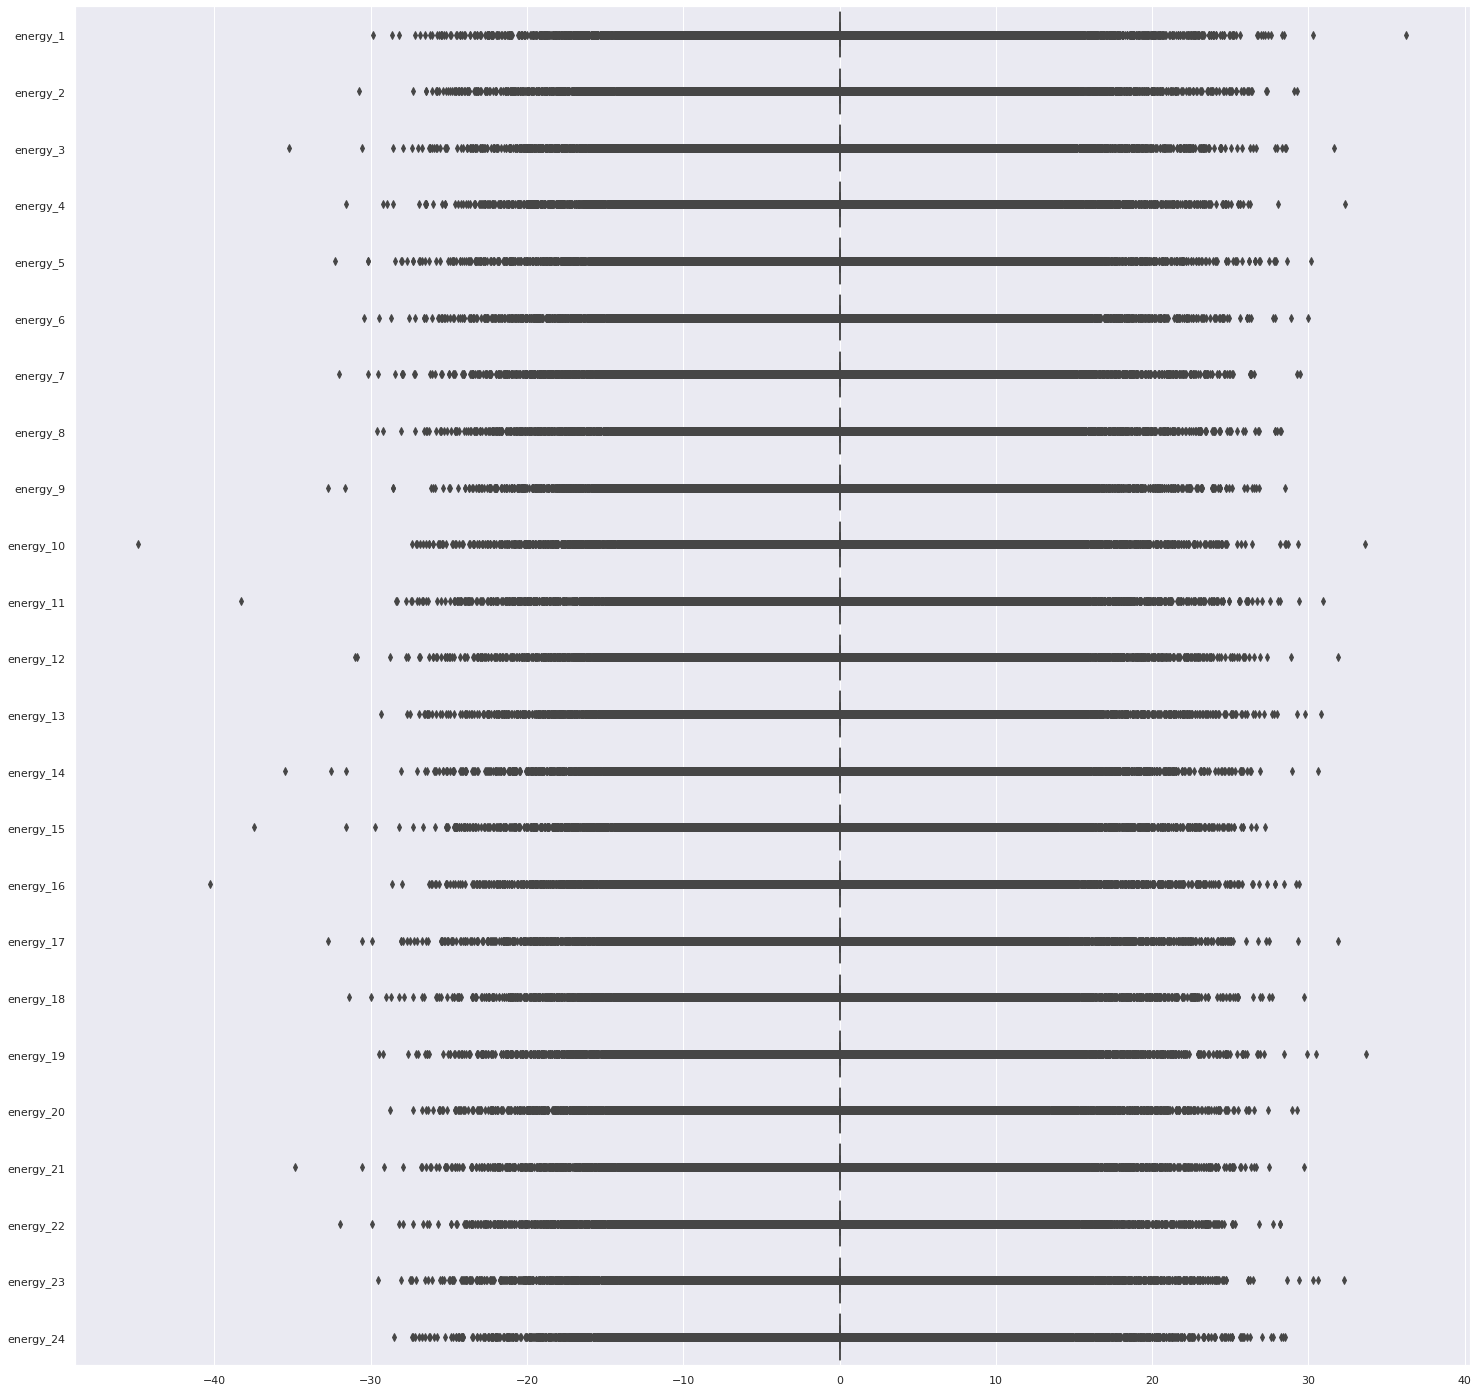

In [66]:
plot_args= {"cut": 0}
f,axs = plt.subplots(1,1,figsize=(25,25))
ax = sns.boxplot(data=df[energy], orient="h")

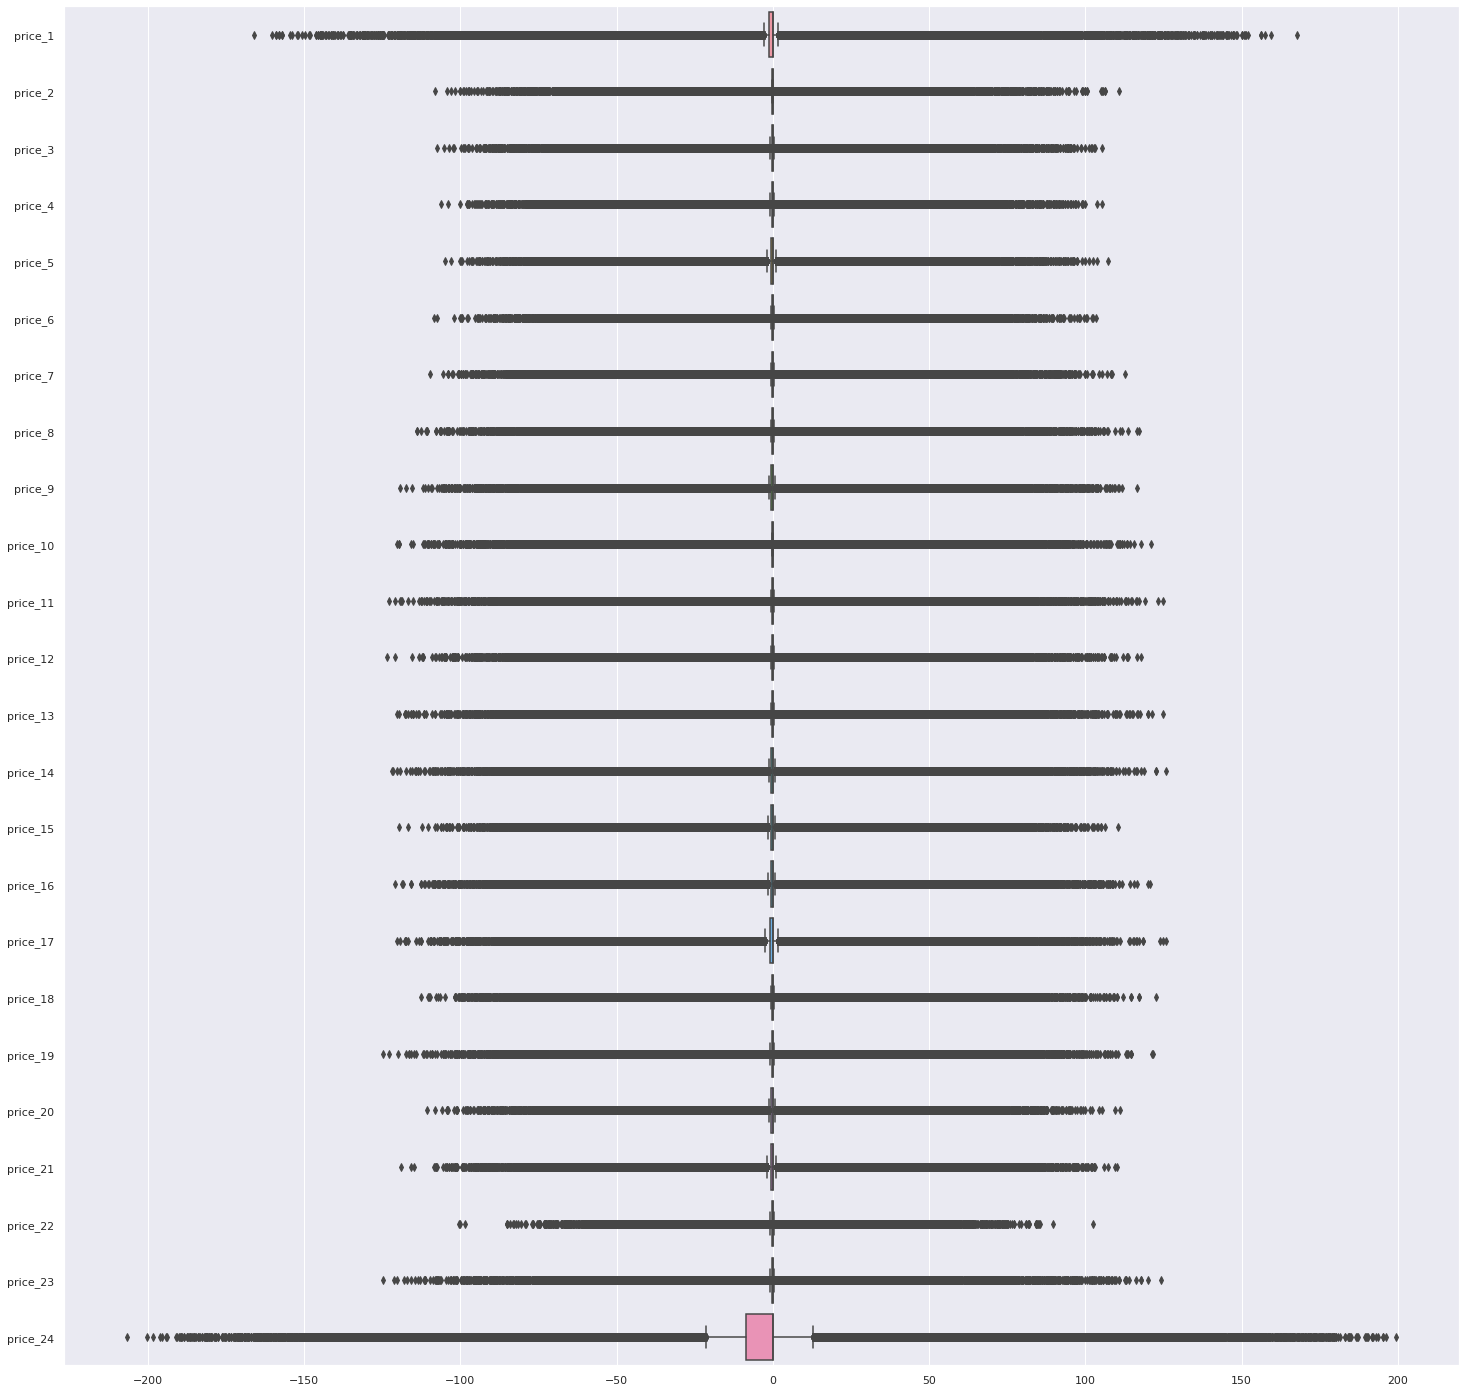

In [67]:
f,axs = plt.subplots(1,1,figsize=(25,25))
ax = sns.boxplot(data=df[price],  orient="h")

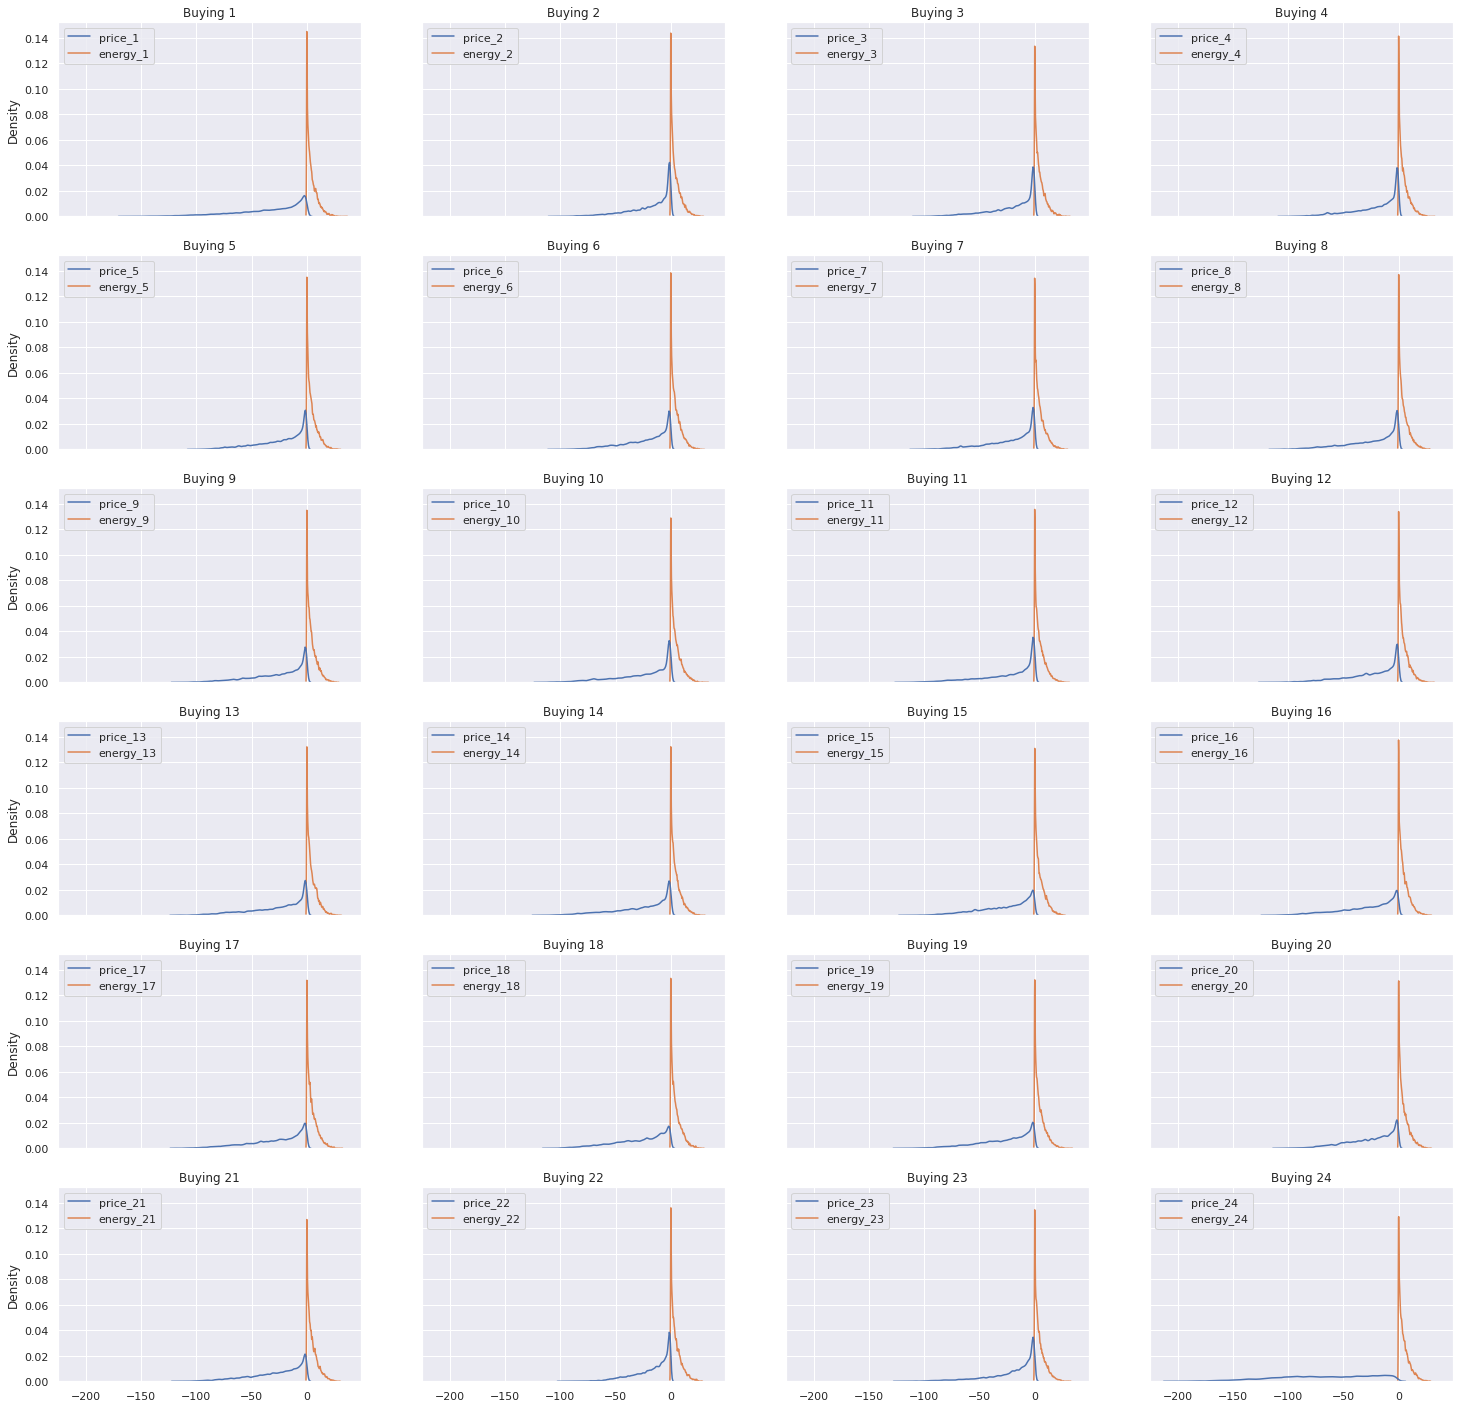

In [68]:
f,axs = plt.subplots(6,4,figsize=(25,25) ,sharex=True, sharey=True)

for i in range(0,24,1):
    df_seleciton = df.loc[df[f"price_{i+1}"]<0]

    j = int(i/4)
    j2 = round(i%4)
    axs[j][j2].set_title(f"Buying {i+1}")
    sns.kdeplot(data=df_seleciton[[f"price_{i+1}", f"energy_{i+1}"]], ax=axs[j][j2], bw_adjust=0.3)


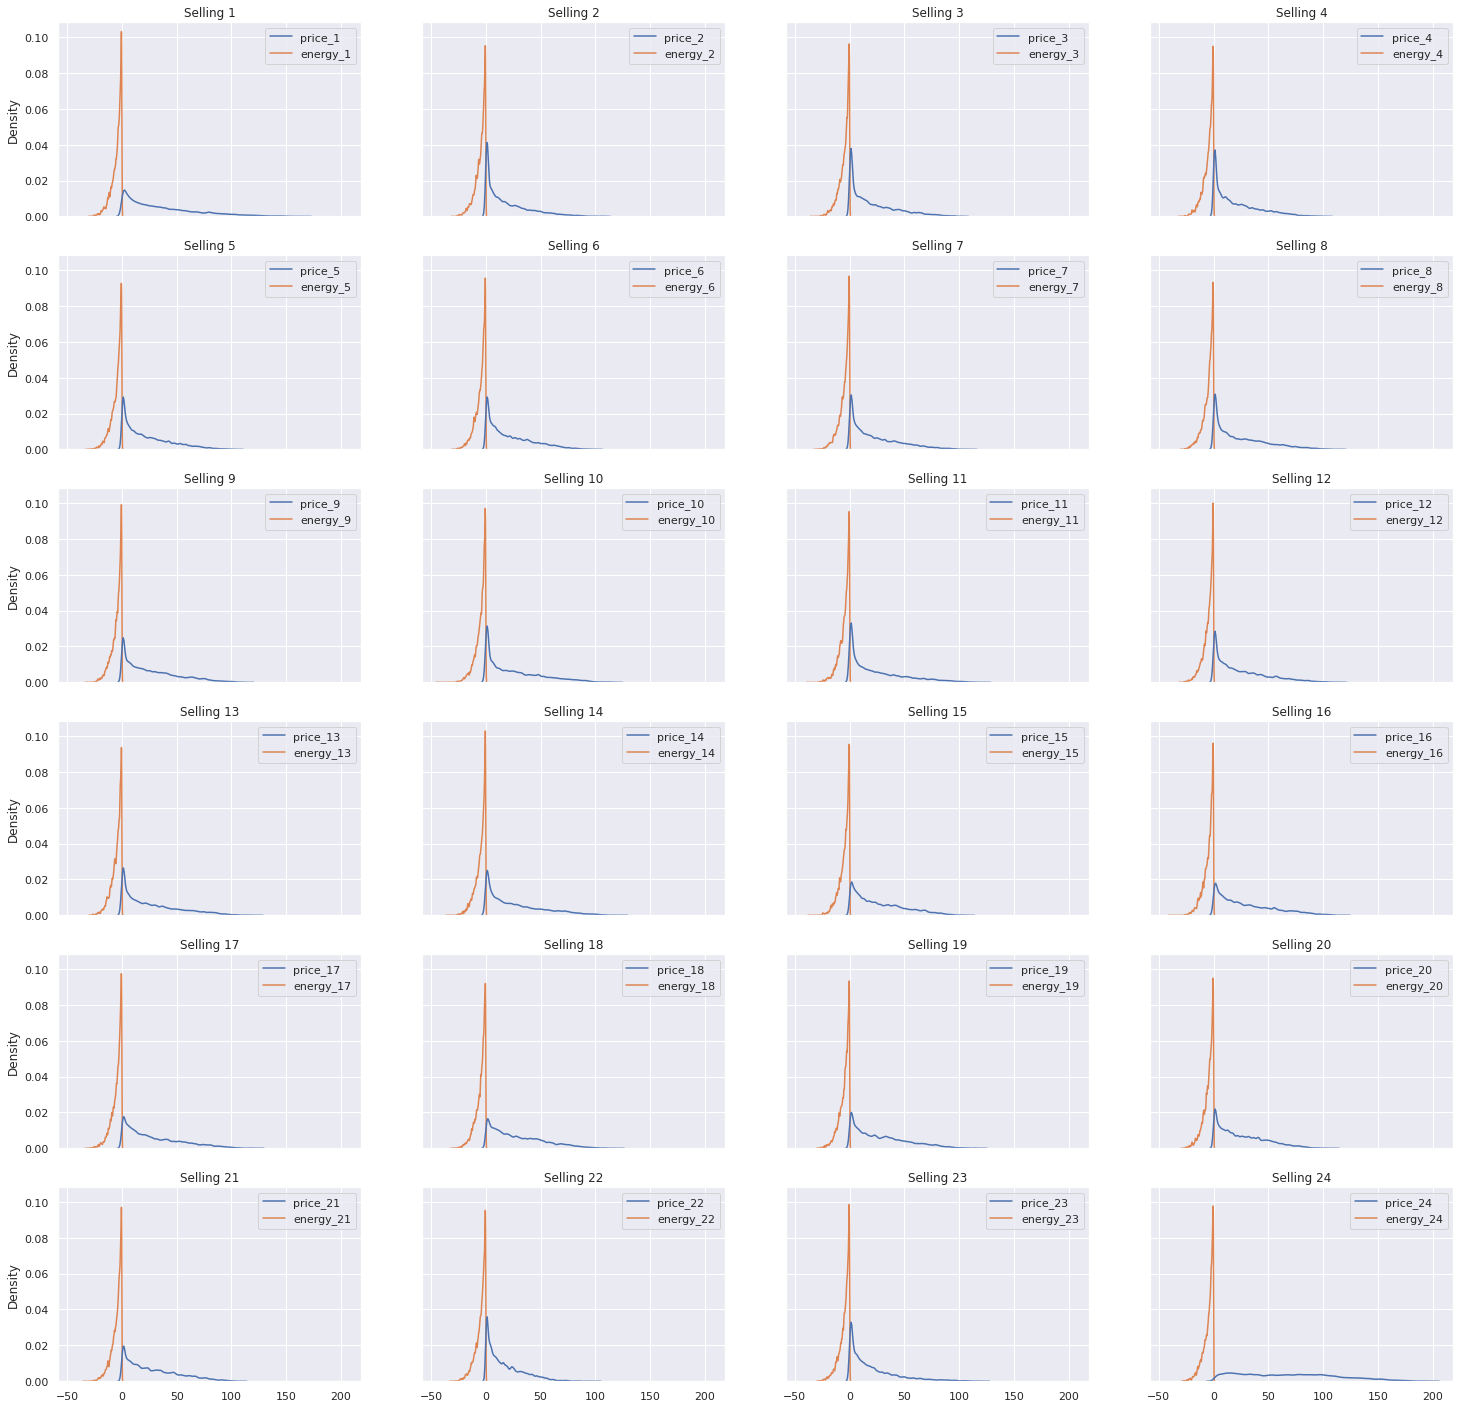

In [69]:
# Selling
from matplotlib.pyplot import title


f,axs = plt.subplots(6,4,figsize=(25,25) ,sharex=True, sharey=True)
for i in range(0,24,1):
    df_seleciton = df.loc[df[f"price_{i+1}"]>0]

    j = int(i/4)
    j2 = round(i%4)
    axs[j][j2].set_title(f"Selling {i+1}")
    sns.kdeplot(data=df_seleciton[[f"price_{i+1}", f"energy_{i+1}"]], ax=axs[j][j2], bw_adjust=0.3)

In [70]:
df[(df["energy_24"] < -0.00000001) | ((df["energy_24"] > 0.000001))][["energy_24", "price_24", "reward"]]

energy_24    price_24    reward
0       0.713889  -61.964924  0.000000
2      -0.621948  148.458129 -0.020944
3      -1.047883   75.622710 -0.043320
6      11.333334 -134.807952 -0.152244
8      -7.446034   52.214901 -0.052091
...          ...         ...       ...
30856  -3.366301   16.081583 -0.542718
30857   6.482724  -95.697161 -0.475548
30858  -1.714591   14.402797 -0.651614
30859  10.044337   -2.985405 -0.655525
30860  -2.242542   94.494688 -0.708448

[15235 rows x 3 columns]

In [71]:
#sns.lineplot(y=df["sum_mWh"], x=df["timeslot"])
#sns.lineplot(y=df["p_customer_prosumption_23"], x=df["timeslot"])